# Statistical Model Forecasting
Model - Prophet

In [6]:
!pip uninstall -y prophet fbprophet
!pip install prophet cmdstanpy


Found existing installation: prophet 1.1.7
Uninstalling prophet-1.1.7:
  Successfully uninstalled prophet-1.1.7
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 40.8 MB/s eta 0:00:00


In [9]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Load your cleaned dataset
df = pd.read_csv("historical_stocks_clean.csv")
df["Date"] = pd.to_datetime(df["Date"])


In [10]:
# Choose one ticker, e.g., Apple
ticker = "AAPL"
data = df[df["Ticker"] == ticker][["Date", "Close"]].rename(columns={"Date": "ds", "Close": "y"})
data = data.sort_values("ds").dropna()


In [11]:
train_size = int(len(data) * 0.8)
val_size = int(len(data) * 0.1)

train = data.iloc[:train_size]
val   = data.iloc[train_size:train_size + val_size]
test  = data.iloc[train_size + val_size:]


In [12]:
m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
m.fit(train)


In [13]:
# Create future dataframe covering all validation + test dates
future = pd.concat([val, test])[["ds"]].reset_index(drop=True)

forecast = m.predict(future)
preds = forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]]
actuals = pd.concat([val, test]).reset_index(drop=True)
results = actuals.merge(preds, on="ds", how="left")


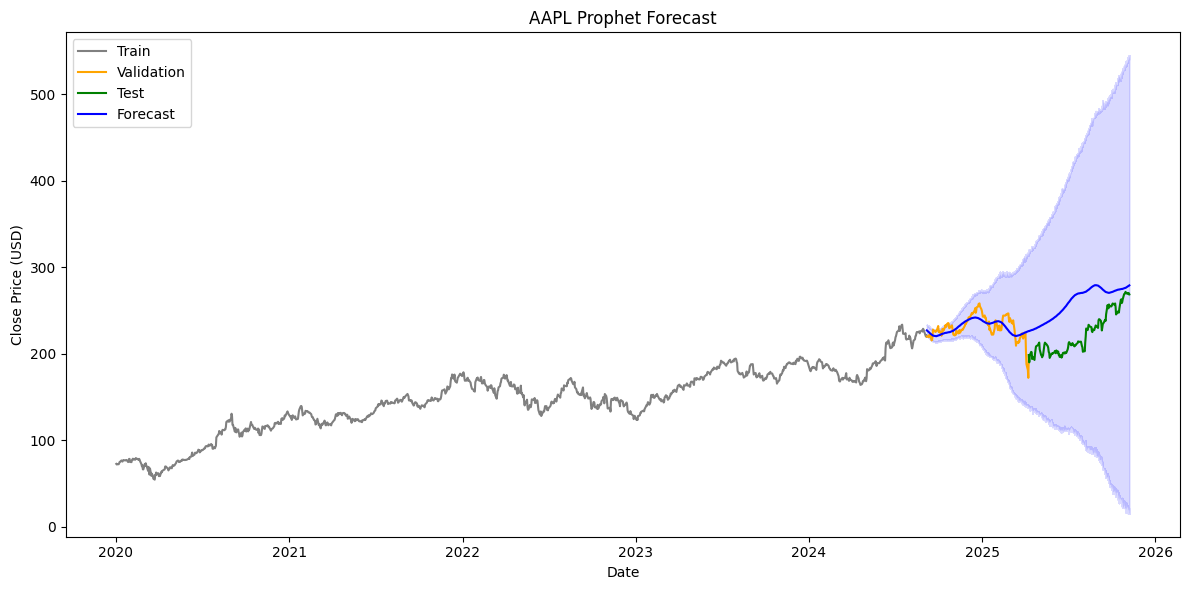

In [14]:
plt.figure(figsize=(12,6))
plt.plot(train["ds"], train["y"], label="Train", color="gray")
plt.plot(val["ds"], val["y"], label="Validation", color="orange")
plt.plot(test["ds"], test["y"], label="Test", color="green")
plt.plot(results["ds"], results["yhat"], label="Forecast", color="blue", linewidth=1.5)
plt.fill_between(results["ds"], results["yhat_lower"], results["yhat_upper"], color="blue", alpha=0.15)
plt.title(f"{ticker} Prophet Forecast")
plt.xlabel("Date"); plt.ylabel("Close Price (USD)")
plt.legend(); plt.tight_layout()
plt.show()


In [18]:
results

,ds,y,yhat,yhat_lower,yhat_upper
0,2024-09-06,219.797058,226.846447,220.071986,233.056342
1,2024-09-06,219.797058,226.846447,220.789234,233.489704
2,2024-09-06,219.797058,226.846447,220.071986,233.056342
3,2024-09-06,219.797058,226.846447,220.789234,233.489704
4,2024-09-09,219.886642,225.489120,219.172043,231.915340
...,...,...,...,...,...
7349,2025-11-07,268.470001,278.938929,15.923707,544.625205
7350,2025-11-07,268.470001,278.938929,15.650317,542.410222
7351,2025-11-07,268.470001,278.938929,14.827213,542.820293
7352,2025-11-07,268.470001,278.938929,18.271865,541.588057


In [19]:
# Evaluate only on test set
test_merge = test.merge(results, on=["ds", "y"], how="left")
mae = mean_absolute_error(test_merge["y"], test_merge["yhat"])
rmse = np.sqrt(mean_squared_error(test_merge["y"], test_merge["yhat"]))

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE:  36.31
RMSE: 39.80
